In [328]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import random
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from collections import namedtuple, deque
import matplotlib.pyplot as plt

In [329]:
def get_other_player(player):
    """
    Get the other opponent player name
    :param player: the current player name
    :return: the opponent player name
    """
    return "X" if player == "O" else "O"
def grid_to_state(grid,  env, player):
    """
    Convert the numpy grid to a tensor according to the definition in the handout
    :param env: the current environement of the game
    :param player: our current learner
    """
    return torch.tensor([grid==env.player2value[player.player], grid==env.player2value[get_other_player(player.player)]],dtype=torch.float).unsqueeze(0) # Might be broken

In [330]:
class DeepQNetwork(nn.Module):
    """
    Class representing our Neural Network to estimate the Q-values of each play
    It is composed of two hidden layers
    """
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(18, 100)
        self.hidden2 = nn.Linear(100, 100)
        self.output = nn.Linear(100, 9)
    def forward(self, x): 
        x = x.flatten(1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        return self.output(x)
    

In [331]:
class ReplayBuffer(object):  
    def __init__(self, capacity):
        self.Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
        self.memory = deque([],maxlen=capacity) 
 
    def push(self, *args): 
        """Save a transition"""
        self.memory.append(self.Transition(*args)) 
 
    def sample(self, batch_size):
        """
        Get a random batch from the replay buffer
        :param batch_size: the size of the batch we want to get
        :return: the random batch
        """
        return random.sample(self.memory, batch_size) 
 
    def __len__(self):
        """
        Return the length of the replay memory
        """
        return len(self.memory)

In [332]:
class DeepQPlayer():
    def __init__(self, model, player="", N_ACTIONS=9): 
        self.model = model
        self.player = player
        
    def act(self, epsilon, env,N_ACTIONS):
        """
        Choose a move to perform for the given grid and the epsilon-greedy policy
        :param epsilon: the epislon value used in the epsilon-greedy policy.
        :param grid: the current state of the game
        """
        if random.random() <= epsilon:
            # Perform a random move
            return torch.tensor(random.randrange(N_ACTIONS)).unsqueeze(-1)
        else:
            # Choose the best action according to the ouptut of the estimation networks.
            state = grid_to_state(env.grid,env, self)
            return self.model(state).argmax().unsqueeze(-1) # potential problem
    

In [349]:
class DeepQTraining():
    def __init__(self):
        # All constants needed in the optimisation 
        self.DISCOUNT_FACTOR = 0.99
        self.BUFFER_SIZE = 10000
        self.BATCH_SIZE = 64
        self.TARGET_NET_UPDATE_STEP = 500
        self.LEARNING_RATE = 5e-4
        self.epoch = 20000
        self.MAX_GAME_LENGTH = 9
        self.turns = np.array(['X','O'])
        self.N_ACTIONS = 9
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.TEST_STEP = 250
        self.NB_TEST_GAME = 500
        self.score_test_opt = []
        self.score_test_rng = []
        
        self.AVG_STEP = 250
        self.avg_reward = []
        
        
    def reset_parameters(self):
        """
        Reset all training parameters to default 
        """
        self.buffer = ReplayBuffer(self.BUFFER_SIZE)
        self.policy_network = DeepQNetwork()
        self.target_network = DeepQNetwork()
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.agent1 = DeepQPlayer(self.policy_network)
        self.agent2 = DeepQPlayer(self.policy_network)
        self.optim = optim.Adam(self.policy_network.parameters(), lr=self.LEARNING_RATE)
        self.criterion = nn.HuberLoss()
        self.env = TictactoeEnv()
        
        self.score_test_opt = []
        self.score_test_rng = []
    
    
    def optimize_model(self):
        """
        Optimise the parameter of the model according to the QDN algorithm
        """
        if len(self.buffer) < self.BATCH_SIZE: 
            return 
        
        samples = self.buffer.sample(self.BATCH_SIZE)
        
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays. 
        # This comes from the PyTorch tutorial
        # Go from [Transition(state='state', action='a', next_state='state2', reward=1)] 
        # to Transition(state=('state',), action=('a',), next_state=('state2',), reward=(1,))
        batch = buffer.Transition(*zip(*samples))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_network(state_batch).gather(1, action_batch.unsqueeze(1))

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.BATCH_SIZE, device=self.device)
        next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1)[0].detach()
        
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.DISCOUNT_FACTOR) + reward_batch
        loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        
        # peform weight updates
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
        
    def test(self, cur_seed):
        """
        Test our learned against a random player and an optimal player
        """
        # Define default values
        nb_win_opt = 0
        nb_lose_opt = 0
        nb_win_rng = 0
        nb_lose_rng = 0
        env_test = TictactoeEnv()
        
        def test_game(opp_eps, epoch, cur_seed):
            """
            Run a test game 
            :param opp_eps: the epsilon for the opponent optimal player
            :param epoch: the current epoch
            :returns: tuple (a, b) with a=1 if our learner wins and b=1 if he looses
            """
            random.seed(cur_seed)
            env_test.reset()
            q_player = self.agent1
            self.agent1.player = self.turns[(epoch+1)%2]
            player_opt = OptimalPlayer(epsilon=opp_eps, player=self.turns[epoch%2])
            
            # When testing we do not update Qvals and set epsilon_learner parameter at 0.0 (no random exploration action)
            self.simulate_game(env_test, player_opt, q_player, 0.0, in_test = True)
            return (1 if env_test.winner == q_player.player else 0), (1 if env_test.winner == player_opt.player else 0)
        
        for ep in range(0, self.NB_TEST_GAME):
            # Simulate games against optimal player and random player
            cur_seed += 1
            win_opt, lose_opt = test_game(0.0, ep, cur_seed)
            cur_seed += 1
            win_rng, lose_rng = test_game(1.0, ep, cur_seed)
            
            # Update the value depending on win or loose
            nb_win_opt += win_opt
            nb_lose_opt += lose_opt
            nb_win_rng += win_rng
            nb_lose_rng += lose_rng
        
        # Store M_opt and M_rand 
        self.score_test_opt.append((nb_win_opt-nb_lose_opt)/self.NB_TEST_GAME)
        self.score_test_rng.append((nb_win_rng-nb_lose_rng)/self.NB_TEST_GAME)
        
    def simulate_game(self, env, opt_player, learner, epsilon_greedy, in_test = False):
        """
        Simulate a full game with the different given player
        :param env: the current environment of the game
        :param opt_player: the player with the optimal policy
        :param learner: our learner
        :param epsilon_greedy: the value to use for epsilon in the epsilon-greedy policy. 
        """
    
        for m in range(self.MAX_GAME_LENGTH):
            # Iterate for the full game 
            if env.current_player == opt_player.player:
                # If it is the turn of the optimal player, simply choose a move. 
                move = opt_player.act(env.grid)
                move_int = move # Get the move as an int
            else:
                # If it is the turn of our learner, choose the best possible action
                move = learner.act(epsilon_greedy, env, self.N_ACTIONS)
                move_int = move.item() # Get the move as an int and not a tensor
            
            # Save current values to store them in the replay buffer later on
            prev_grid = env.grid.copy()
            round_player = env.current_player
            
            if env.check_valid(move_int):
                # If the chosen move is valid, perform it and ovserve the reward
                _, end, winner = env.step(move_int)
                reward = env.reward(round_player)
            else:
                # If the chosen move is not valid, end the game and store a reward of -1
                end = True
                reward = -1
                    
            if learner.player == round_player and not in_test:
                # If it is our learner turn, store the current state, chosen action, reward and next state in the replay buffer
                self.save_to_buffer_memory(prev_grid, learner, move, end, reward)
                
            if end:
                # End the simulation of the game if the game is over
                return
            
    def save_to_buffer_memory(self, prev_grid, learner, move, end, reward):
        # We set the next state to None if the game is ended.
        cur_reward = torch.tensor(reward).unsqueeze(-1)
        cur_state = grid_to_state(prev_grid, self.env, learner)
        cur_move = move
        next_state = None if end else grid_to_state(self.env.grid.copy(), self.env, learner)
        self.buffer.push(cur_state, cur_move, next_state, cur_reward)
                
                    
    def train(self, epsilon_greedy, adversary_epsilon, run_test = True, seed=42):
        # set seed for reproducible results
        torch.manual_seed(seed)
        random.seed(seed)
        
        # Reset all the parameters for the start of the trianing
        self.reset_parameters()
        acc_rew = 0
        for e in tqdm(range(self.epoch)):
            self.env.reset()
            
            seed+=1
            random.seed(seed)
            
            if((e+1)%self.TEST_STEP == 0):
                self.test(seed)
                
            if((e+1)%self.AVG_STEP == 0):
                self.avg_reward.append(acc_rew/self.AVG_STEP)
                acc_rew = 0
            
            # set the corret player names
            self.agent1.player = self.turns[(e+1)%2]
            opt_player = OptimalPlayer(adversary_epsilon, player=self.turns[e%2])
            
            # Simulate a game for the current epoch  
            self.simulate_game(self.env, opt_player, self.agent1, epsilon_greedy(e))
            
            acc_rew += self.env.reward(self.agent1)
            
            # Perform one step of optimization (on the policy network)
            self.optimize_model()
                                          
            if (e+1)%self.TARGET_NET_UPDATE_STEP == 0:
                # If we reach the update epoch, update the parameters in the target networ.
                self.target_network.load_state_dict(self.policy_network.state_dict())
                
                
    def plot_mean_reward_during_training(self):
        """
        Make a plot with the mean reward gotten during training
        """
        plt.figure(figsize=(20, 10))
        plt.plot(range(0, self.epoch, self.AVG_STEP), self.avg_reward, 'b', lw=4)
        plt.xlabel('Number of games played', fontsize= 20)
        plt.ylabel('Mean reward over {} games'.format(self.AVG_STEP), fontsize = 20)
        plt.title('Evolution of mean reward (every {} games played) of the learner'.format(self.AVG_STEP), fontsize = 20)
        plt.grid()
        plt.show()
        
    def plot_mopt_mrng_during_training(self):
        """
        Make a plot with the performance against optimal and random players
        """
        plt.figure(figsize=(20, 10))
        plt.plot(range(0, self.epoch, self.TEST_STEP), self.score_test_opt, color='blue', lw=4, label="Against Optimal Player")
        plt.plot(range(0, self.epoch, self.TEST_STEP), self.score_test_rng, color='orange', lw=4, label="Against Random Player")
        plt.xlabel('Number of games played', fontsize= 20)
        plt.ylabel('Mean reward over {} games'.format(self.TEST_STEP), fontsize = 20)
        plt.legend(loc=2)
        plt.title('Evolution of mean reward (every {} games played) of the learner'.format(self.TEST_STEP), fontsize = 20)
        plt.grid()
        plt.show()

In [ ]:
trainer = DeepQTraining()
trainer.train(lambda e: 0.1, 1.0)

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 12237/20000 [01:59<00:34, 223.56it/s]

In [ ]:
trainer.plot_mean_reward_during_training()

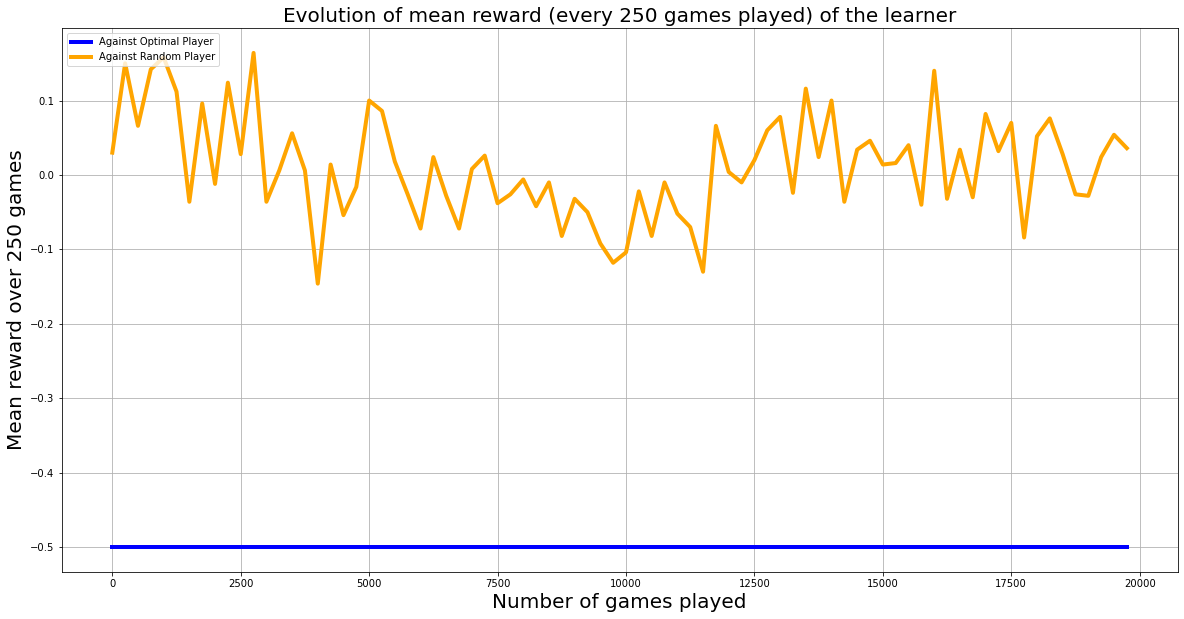

In [320]:
trainer.plot_mopt_mrng_during_training()